<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


**<font color='red'>Plagiarism is strongly prohibited!</font>**


**Student Name**: Ali Yousefi

**Student ID**: 99109111





## Importing Libraries

First we import libraries that we need for this assignment.

In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
# import any other libraries needed below

## Reading Data and Preprocessing

In this section, we want to read data from a CSV file and then preprocess it to make it ready for the rest of the problem.

First, we read the data in the cell below and extract an $m \times n$ matrix, $X$, and an $m \times 1$ vector, $Y$, from it, which represent our knowledge about the features of the data (`X1`, `X2`, `X3`) and the class (`Y`), respectively. Note that by $m$, we mean the number of data points and by $n$, we mean the number of features.

In [256]:
X, Y = None, None

# Read the data from the cell and convert it into a pandas DataFrame
data = pd.read_csv('/data_logistic.csv')
data.head()



,X1,X2,X3,Y
0,212.333644,327.382173,259.683281,1
1,80.919786,1006.053094,446.516485,1
2,578.734414,994.692630,690.134343,1
3,305.032631,129.330782,300.859310,0
4,619.632739,640.433450,398.845694,1


In [257]:

X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values



print(X.shape)
print(Y.shape)

(10000, 3)
(10000,)


Next, we should normalize our data. For normalizing a vector $\mathbf{x}$, a very common method is to use this formula:

$$
\mathbf{x}_{norm} = \dfrac{\mathbf{x} - \overline{\mathbf{x}}}{\sigma_\mathbf{x}}
$$

Here, $\overline{x}$ and $\sigma_\mathbf{x}$ denote the mean and standard deviation of vector $\mathbf{x}$, respectively. Use this formula and store the new $X$ and $Y$ vectors in the cell below.

**Question**: Briefly explain why we need to normalize our data before starting the training.

**Answer**: Normalizing data can reduce the impact of outliers, and decrease the chances of overfitting. It can also help to reduce data redundancy and improve data integrity, making future updates and scalability more efficient.

Normalizing data can also help improve the accuracy of predictions for some machine learning algorithms, such as k-nearest neighbors and support vector machines, which are sensitive to the scale of the data.


In [258]:
# Compute the mean and standard deviation of each column of X
mean_x = np.mean(X, axis=0)
std_x = np.std(X, axis=0)

# Normalize X using the formula
X_norm = (X - mean_x) / std_x
Y_norm=Y

# Print the normalized matrix X and vector Y
print('Normalized Matrix X:')
print(X_norm)
print('\nNormalized Vector Y:')
print(Y_norm)

Normalized Matrix X:
[[-1.00066149 -0.60536985 -0.85021999]
 [-1.45366949  1.73051062 -0.20238503]
 [ 0.26239007  1.69140966  0.64234794]
 ...
 [ 1.35418019 -0.1188587   1.41249602]
 [ 1.41727838  0.76498604  0.94404812]
 [ 0.79312016  1.49592029  0.85670437]]

Normalized Vector Y:
[1 1 1 ... 0 1 1]


Finally, we should add a column of $1$s at the beginning of $X$ to represent the bias term. Do this in the next cell. Note that after this process, $X$ should be an $m \times (n+1)$ matrix.

In [259]:
m=10000
bias = np.ones((m, 1))
X_norm = np.concatenate((bias, X_norm), axis=1)
print(X_norm.shape)

(10000, 4)


## Training Model

### Sigmoid Function
You should begin by implementing the $\sigma(\mathbf{x})$ function. Recall that the logistic regression hypothesis $\mathcal{h}()$ is defined as:
$$
\mathcal{h}_{\theta}(\mathbf{x}) = \mathcal{g}(\theta^\mathbf{T}\mathbf{x})
$$
where $\mathcal{g}()$ is the sigmoid function as:
$$
\mathcal{g}(\mathbf{z}) = \frac{1}{1+exp^{-\mathbf{z}}}
$$
The Sigmoid function has the property that $\mathbf{g}(+\infty)\approx 1$ and $\mathcal{g}(−\infty)\approx0$. Test your function by calling `sigmoid(z)` on different test samples. Be certain that your sigmoid function works with both vectors and matrices - for either a vector or a matrix, your function should perform the sigmoid function on every element.

In [260]:
import numpy as np

def sigmoid(z):
    """
    Compute the sigmoid function for a scalar, vector, or matrix.

    Args:
        z (float, numpy array): Input value(s).

    Returns:
        float, numpy array: Sigmoid output(s).
    """
    return 1 / (1 + np.exp(-z))

# Test the sigmoid function
test_scalar = 2.5
test_vector = np.array([-1, 0, 1])
test_matrix = np.array([[1, 2], [-2, 0]])

print(f"Sigmoid({test_scalar}) = {sigmoid(test_scalar)}")
print(f"Sigmoid({test_vector}) = {sigmoid(test_vector)}")
print(f"Sigmoid({test_matrix}) =\n{sigmoid(test_matrix)}")


Sigmoid(2.5) = 0.9241418199787566
Sigmoid([-1  0  1]) = [0.26894142 0.5        0.73105858]
Sigmoid([[ 1  2]
 [-2  0]]) =
[[0.73105858 0.88079708]
 [0.11920292 0.5       ]]


### Cost Function
Implement the functions to compute the cost function. Recall the cost function for logistic regression is a scalar value given by:
$$
\mathcal{J}(\theta) = \sum_{i=1}^{n}[-y^{(i)}\log{(\mathcal{h}_\theta(\mathbf{x}^{(i)}))}-(1-y^{(i)})\log{(1-\mathcal{h}_\theta(\mathbf{x}^{(i)}))}] + \frac{\lambda}{2}||\theta||_2^2
$$

In [261]:
def computeCost(theta, X, y, regLambda):
    '''
    Computes the objective function
    Arguments:
        theta is d-dimensional numpy vector
        X is a n-by-d numpy matrix
        y is an n-dimensional numpy vector
        regLambda is the scalar regularization constant
    Returns:
        a scalar value of the cost  ** make certain you're not returning a 1 x 1 matrix! **
    '''

    m, n = X.shape
    cost= None
    u = sigmoid(X@theta)

    # Calculate the cost without regularization
    cost = np.sum(-y * np.log(u) -(1 - y) * np.log(1 - u)) / m

    regularization = (regLambda/2) * np.sum(theta[1:]**2)

    return cost + regularization


### Gradient of the Cost Function
Now, we want to calculate the gradient of the cost function. The gradient of the cost function is a d-dimensional vector.\
We must be careful not to regularize the $\theta_0$ parameter (corresponding to the first feature we add to each instance), and so the 0's element is given by:
$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta_0} = \sum_{i=1}^n (\mathcal{h}_\theta(\mathbf{x}^{(i)})-y^{(i)})
$$

Question: What is the answer to this problem for the $j^{th}$ element (for $j=1...d$)?

Answer:
The $j^{th}$ element of the gradient of the cost function is given by:

$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta_j} = \frac{1}{n}\sum_{i=1}^n (h_\theta(\mathbf{x}^{(i)})-y^{(i)})x_j^{(i)}+\lambda \theta_j
$$

This is because the gradient of the cost function is a d-dimensional vector, with the $j^{th}$ element being the derivative of the cost function with respect to the $j^{th}$ parameter, $\theta_j$. The $j^{th}$ parameter is multiplied by $x_j^{(i)}$ in the hypothesis function $h_\theta(\mathbf{x}^{(i)}) = \theta_0 + \theta_1x_1^{(i)} + \cdots + \theta_dx_d^{(i)}$, so the derivative with respect to $\theta_j$ will be $x_j^{(i)}$. The sum is taken over all training examples $i=1, \ldots, n$ to get the total gradient.

In [262]:
import numpy as np

def computeGradient(theta, X, y, regLambda):
    """
    Computes the gradient of the objective function for logistic regression.

    Args:
        theta (numpy array): d-dimensional vector (model parameters).
        X (numpy array): n-by-d matrix (feature matrix).
        y (numpy array): n-dimensional vector (target labels).
        regLambda (float): Scalar regularization constant.

    Returns:
        grad (numpy array): d-dimensional vector (gradient).
    """
    n, d = X.shape
    error = sigmoid(X @ theta) - y
    grad = (X.T @ error) / n

    # Add regularization to the gradient
    reg = (regLambda / n) * theta
    reg[0] = 0
    grad += reg

    return grad

### Training and Prediction
Once you have the cost and gradient functions complete, implemen tthe fit and predict methods.\
Your fit method should train the model via gradient descent, relying on the cost and gradient functions. This function should return two parameters. The first parameter is $\theta$, and the second parameter is a `numpy` array that contains the loss in each iteration. This array is indicated by `loss_history` in the code.\
Instead of simply running gradient descent for a specific number of iterations, we will use a more sophisticated method: we will stop it after the solution hasconverged. Stop the gradient descent procedure when $\theta$ stops changing between consecutive iterations. You can detect this convergence when:
$$
||\theta_{new}-\theta_{old}||_2 <= \epsilon,
$$
for some small $\epsilon$ (e.g, $\epsilon=10E-4$).\
For readability, we’d recommend implementing this convergence test as a dedicated function `hasConverged`.

In [263]:
def fit(X, y, regLambda = 0.01, alpha = 0.01, epsilon = 1e-4, maxNumIters = 100):
    '''
    Trains the model
    Arguments:
        X           is a n-by-d numpy matrix
        y           is an n-dimensional numpy vector
        maxNumIters is the maximum number of gradient descent iterations
        regLambda   is the scalar regularization constant
        epsilon     is the convergence rate
        alpha       is the gradient descent learning rate
    '''
    # Initialize theta
    m, n = X.shape

    theta = np.zeros(n)

    # Initialize loss history
    loss_history = []

    for iteration in range(maxNumIters):
        theta_old = np.copy(theta)
       # Compute gradient
        grad = computeGradient(theta,X, y, regLambda)

        # Update theta using gradient descent
        theta-=alpha * grad

        # Compute cost and add to loss history
        cost = computeCost(theta,X, y, regLambda)
        loss_history.append(cost)

        if hasConverged(theta_old, theta, epsilon):
            break

    return theta, np.array(loss_history)






def hasConverged(theta_old, theta_new, epsilon):
    '''
    Return if the theta converged or not
    Arguments:
        theta_old   is the theta calculated in prevoius iteration
        theta_new   is the theta calculated in current iteration
        epsilon     is the convergence rate
    '''

        # Check if ||theta_new - theta_old||_2 <= epsilon
    return np.linalg.norm(theta_new - theta_old,2) <= epsilon


Finally, we want to evaluate our loss for this problem. Complete the cell below to calculate and print the loss of each iteration and the final theta of your model.

In [264]:
theta, loss_history = fit(X_norm, Y_norm) # calculating theta and loss of each iteration

# Print loss for each iteration
for iteration, loss in enumerate(loss_history):
    print(f"Iteration {iteration + 1}: Loss = {loss.flatten()}")

# Print final theta
print("Final theta:", theta)
# y h x theta

Iteration 1: Loss = [0.69148697]
Iteration 2: Loss = [0.68983527]
Iteration 3: Loss = [0.68819202]
Iteration 4: Loss = [0.68655719]
Iteration 5: Loss = [0.68493073]
Iteration 6: Loss = [0.6833126]
Iteration 7: Loss = [0.68170275]
Iteration 8: Loss = [0.68010115]
Iteration 9: Loss = [0.67850774]
Iteration 10: Loss = [0.67692249]
Iteration 11: Loss = [0.67534536]
Iteration 12: Loss = [0.67377629]
Iteration 13: Loss = [0.67221525]
Iteration 14: Loss = [0.67066219]
Iteration 15: Loss = [0.66911708]
Iteration 16: Loss = [0.66757987]
Iteration 17: Loss = [0.66605051]
Iteration 18: Loss = [0.66452896]
Iteration 19: Loss = [0.66301519]
Iteration 20: Loss = [0.66150915]
Iteration 21: Loss = [0.6600108]
Iteration 22: Loss = [0.65852009]
Iteration 23: Loss = [0.65703699]
Iteration 24: Loss = [0.65556145]
Iteration 25: Loss = [0.65409343]
Iteration 26: Loss = [0.65263289]
Iteration 27: Loss = [0.65117979]
Iteration 28: Loss = [0.64973408]
Iteration 29: Loss = [0.64829574]
Iteration 30: Loss = [0.6

### Testing Your Implementation
To test your logistic regression implementation, first you should use `train_test_split` function to split dataset into three parts:

- 70% for the training set
- 20% for the validation set
- 10% for the test set

Do this in the cell below.

In [265]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = None, None, None, None, None, None

X_train, X_temp, y_train, y_temp = train_test_split(X_norm, Y_norm, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

Then, you should complete `predict` function to find the weight vector and the loss on the test data.

In [266]:
def predict(X, theta):
    '''
    Use the model to predict values for each instance in X
    Arguments:
        theta: d-dimensional numpy vector
        X: n-by-d numpy matrix
    Returns:
        Y: n-dimensional numpy vector of the predictions (binary)
    '''
    # Compute the raw scores (logits) using the learned parameters
    logits = np.dot(X, theta)

    # Apply the sigmoid function to get probabilities
    probabilities = 1 / (1 + np.exp(-logits))

    # Threshold probabilities to obtain binary predictions
    Y = (probabilities > 0.5).astype(int)

    return Y



Now, run the `fit` and `predict` function for different values of the learning rate and regularization constant. Plot the `loss_history` of these different values for train and test data both in the same figure.

**Question**: Discuss the effect of the learning rate and regularization constant and find the best values of these parameters.

**Answer**:Learning Rate (LR):

High Learning Rate: If the learning rate is too high, the model might overshoot the optimal solution and fail to converge. It can lead to divergence.

Low Learning Rate: If the learning rate is too low, the model converges slowly, requiring more iterations.


Regularization Constant (λ):

High λ (Strong Regularization):

Shrinks coefficients significantly.
Simpler models with fewer features.
Helps prevent overfitting.

Low λ (Weak Regularization):
Allows larger coefficients.
More complex models.
Risk of overfitting.

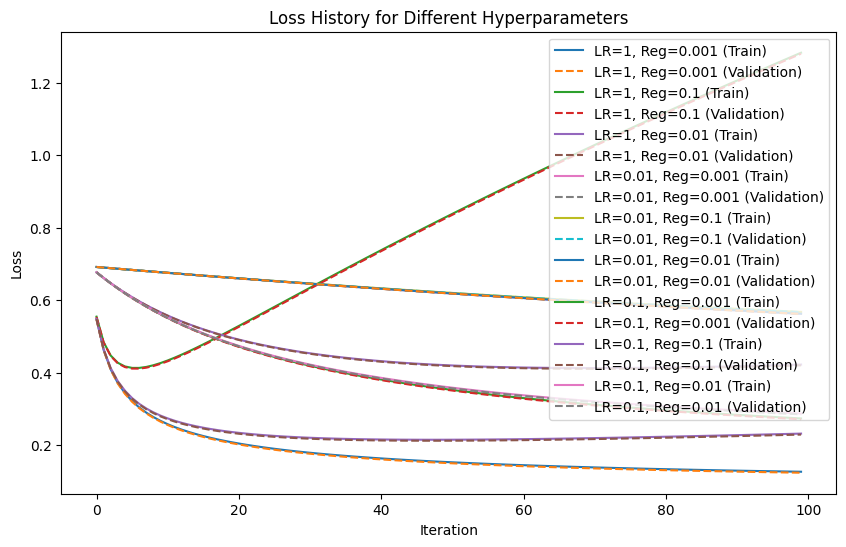

accuracy :  0.9929292929292929


In [267]:
learning_rates = [1, 0.01, 0.1]  # Example learning rates
regularization_constants = [0.001, 0.1, 0.01]  # Example regularization constants

# Initialize dictionaries to store loss history for each hyperparameter setting
train_loss_history = {}
val_loss_history = {}
def val_Loss(X_train, Y_train, X_test, Y_test, alpha, regLambda, maxNumIters=100):
    m, n = X_train.shape
    theta = np.zeros(n)
    loss_history = []

    for _ in range(maxNumIters):
        gradient = computeGradient(theta, X_train, Y_train, regLambda)
        theta -= alpha * gradient
        test_loss = computeCost(theta, X_test, Y_test, regLambda)
        loss_history.append(test_loss)

    return loss_history

for lr in learning_rates:
    for reg_const in regularization_constants:
        # Train the model
        optimal_theta, loss_history = fit(X_train, y_train,reg_const,lr)

        # Predict on validation data
        val_predictions = predict(X_val,optimal_theta)

        # Compute loss on training and validation data
        val_loss = val_Loss(X_train, y_train,X_val,y_val,lr,reg_const)

        # Store loss history
        train_loss_history[(lr, reg_const)] = loss_history
        val_loss_history[(lr, reg_const)] = val_loss

# Plot loss history
plt.figure(figsize=(10, 6))
for lr, reg_const in train_loss_history:
    plt.plot(train_loss_history[(lr, reg_const)], label=f"LR={lr}, Reg={reg_const} (Train)")
    plt.plot(val_loss_history[(lr, reg_const)], linestyle="--", label=f"LR={lr}, Reg={reg_const} (Validation)")

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss History for Different Hyperparameters")
plt.legend()
plt.show()
Y_pred = predict(X_test,theta)
accuracy = accuracy_score(y_test, Y_pred)
print('accuracy : ',accuracy)


## Naive Bayes

In this part, you will use the `GaussianNB` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**:

After training, we evaluate the model’s performance on unseen data (test set). The test accuracy indicates how well the model generalizes to new examples.

 the test accuracy would be 92.83%

In [268]:
# Assuming you have X_train, y_train, X_test, y_test (train and test data)
clf = GaussianNB()  # Initialize the Gaussian Naive Bayes classifier
clf.fit(X_train, y_train.ravel())  # Train the classifier on the training data

# Predict labels for the test data
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.4f}")


Accuracy on the test set: 0.9283


## LDA (Linear Discriminant Analysis)

In this part, you will use the `LinearDiscriminantAnalysis` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**: The Linear Discriminant Analysis (LDA) classifier achieved an accuracy of approximately 0.97 on the test set. This indicates that it correctly predicted the labels for 98% of the unseen data samples

In [269]:
# Initialize the LDA classifier
lda_classifier = LinearDiscriminantAnalysis()

# Train the classifier on the training set
lda_classifier.fit(X_train, y_train.ravel())

# Predict the labels for the test set
y_pred = lda_classifier.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.2f}")


Accuracy on the test set: 0.98


## Conclution

**Question**: What is the best method for classifying this dataset? What is the best accuracy on the test set?

**Answer**: the best acucuracy is for Logistic regression after that LDA (Linear Discriminant Analysis) with 99.3% and 98% accuracy
so the best method for calssifying boston dataset is *Logistic regression*